In [1]:
from src import data_setup, engine, utils, models
from importlib import reload

[reload(m) for m in (data_setup, engine, utils, models)]
device = engine.initialize()

[CONNECTED] NVIDIA GeForce RTX 3070


In [2]:
import torch
from torchvision.datasets import OxfordIIITPet as SET
from torchvision.transforms import ToTensor, Compose, Resize, TrivialAugmentWide
from matplotlib import pyplot as plt
from pathlib import Path

class ToDevice:
    def __init__(self):
        self.device = device
    def __call__(self, x):
        return x.to(self.device)

IMG_SIZE = 64
transform = Compose([
    Resize((IMG_SIZE, IMG_SIZE)),
    TrivialAugmentWide(num_magnitude_bins=8),
    ToTensor(), lambda x: x*2 - 1,
    ToDevice()])

data_dir = Path('data')
torch.set_default_device(device)
args_list = [{'root': data_dir, 'split': s, 'transform': transform, 'download': True} for s in ('trainval', 'test')]
data = [SET(**args) for args in args_list]
data

[Dataset OxfordIIITPet
     Number of datapoints: 3680
     Root location: data
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=8, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
                <function <lambda> at 0x7ff779587eb0>
            ),
 Dataset OxfordIIITPet
     Number of datapoints: 3669
     Root location: data
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=8, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
                <function <lambda> at 0x7ff779587eb0>
            )]

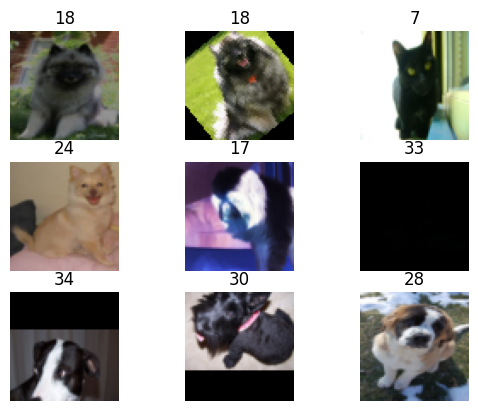

In [3]:
from torch.utils.data import DataLoader
loader = DataLoader(data[0], shuffle=True, generator=torch.Generator(device='cuda'))
utils.visualize(loader, 9, transform=lambda x: (x+1)/2)

### Diffusion Model Steps:
1. The forward process = Noise Schedular
2. The backward process = U-Net
3. The loss

In [4]:
from torch.nn import functional as F
def linear_beta_schedular(timesteps, start=1e-4, end=2e-2):
    return torch.linspace(start, end, timesteps)

# Define beta schedule
T = 200
betas = linear_beta_schedular(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod) / (1. - alphas_cumprod)

In [5]:
def get_index_from_list(
        vals: torch.Tensor, t: torch.Tensor, x_shape: torch.Size
):
    """
    :param vals: torch vector
    :param t:
    :param x_shape: image shape
    :return:
        A specific index t of a passed list of values vals
        while considering the batch dimension.
    """

    batch_size = t.shape[0]
    out = vals.gather(-1, t)
    return out.reshape(batch_size, *( [1,] * (len(x_shape)-1) )).to(t.device)

def forward_diffusion_sample(x_0: torch.Tensor, t: torch.Tensor):
    """
    :param x_0: Original Image. Shape -> (c, h, w)
    :param t: Diffusion timestep. Shape -> (b, 1)
    :return: The noisy version of x_0 at t
    """

    noise = torch.rand_like(x_0)  # Uniform distribution [0, 1)
    sqrt_alphas_cumprod_t = \
        get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = \
        get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape)

    # x_t = sqrt(a)*x_0 + sqrt(1-a)*ε
    return sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise, noise

In [6]:
# demo
def plot_imgs(imgs):
    plt.figure()
    n = len(imgs)
    for i, img in enumerate(imgs):
        plt.subplot(1,n,i+1)
        print(type(img))
        img = (img.detach().cpu().permute(1,2,0)+1)/2
        plt.imshow(img)
        plt.axis('off')

x_0 = next(iter(loader))[0][0]

t_all = []
for i in (5, 10, 20, 50, 80, 100, 150, 200):
    t = torch.tensor([i], dtype=torch.int64, device=device)
    x_t = forward_diffusion_sample(x_0, t)[0]
    t_all.append(x_t)

# plot_imgs([x_0, *t_all])

In [8]:
t_all

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
